In [1]:
import torch
import torch.optim as optim
from datasets import load_dataset
from tools import *
from model import *
from train import *
from plot import *
from eval import *
import pandas as pd

In [2]:
# https://huggingface.co/datasets/yoshitomo-matsubara/srsd-feynman_easy
dataset = load_dataset('yoshitomo-matsubara/srsd-feynman_easy')

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [3]:
def run_experiment(formuler, dataset, n_equation, plot=False, save=True, dist=True, scinet=False):
    train_loader, test_loader, features_, labels_, features, labels = prepare_data_loaders(dataset, n_equation, batch_size=batch_size, equation_size=equation_size, scinet=scinet)
    hist_train_loss, hist_test_loss = train_model(formuler, train_loader, test_loader, optimizer, criterion, scheduler, num_epochs)
    if plot:
        plot_loss_curves(hist_train_loss, hist_test_loss, start=0)
        # Plotting for training data
        x_train, formula_train = formuler(features_.to(device))
        x_train = x_train.detach().cpu()
        print(criterion(x_train.squeeze(1), labels_))
        print(features_.shape)
        plot_grid(features_, x_train, labels_, "Train")

        # Plotting for testing data
        x_test, formula_test = formuler(features.to(device))
        x_test = x_test.detach().cpu()
        print(criterion(x_test.squeeze(1), labels))
        print(features.shape)
        plot_grid(features, x_test, labels, "Test")
        if dist:
            plot_gradient_distributions(formuler, features_, device)

    min_loss, min_for = generate_minimal_loss_formula(formuler, features, features_, labels, device, criterion, model, prob_size=prob_size)
    if plot:
        x = decode(min_for, features.to(device))
        print(criterion(x.squeeze(1).requires_grad_(), labels.to(device)).detach().cpu())
        x = x.detach().cpu()
        plot_grid(features, x, labels, "predicted formula")
    if save:
        torch.save(model, f'saved_models\model-formula-{n_equation}.pth')
    return min_loss, min_for


### Experiment
Choose the formulas you want to find by selecting them in the equations list

<!-- An empty line here -->
<!-- An empty line here -->

![problems](problem_table.png)


4
EPOCH[0] test loss: 0.676689, train loss: 2371716.750000, weighted_loss: 59539554304.000000
EPOCH[1] test loss: 0.680724, train loss: 8.586833, weighted_loss: 12056.225586
EPOCH[2] test loss: 0.680199, train loss: 1126.514771, weighted_loss: 6706002.000000
EPOCH[3] test loss: 0.677386, train loss: 295.317871, weighted_loss: 926233.062500
EPOCH[4] test loss: 0.683600, train loss: 3.454020, weighted_loss: 1868.512085
EPOCH[5] test loss: 0.712326, train loss: 54.097210, weighted_loss: 73179.992188
EPOCH[6] test loss: 0.748918, train loss: 243609.859375, weighted_loss: 2970442496.000000
EPOCH[7] test loss: 0.811791, train loss: 0.248305, weighted_loss: 40.335922
EPOCH[8] test loss: 0.864771, train loss: 0.914313, weighted_loss: 1524.168335
EPOCH[9] test loss: 0.893234, train loss: 0.807294, weighted_loss: 647.624695
EPOCH[10] test loss: 0.897852, train loss: 0.468519, weighted_loss: 577.394531
EPOCH[11] test loss: 0.905016, train loss: 257.532532, weighted_loss: 2345575.000000
EPOCH[12] 

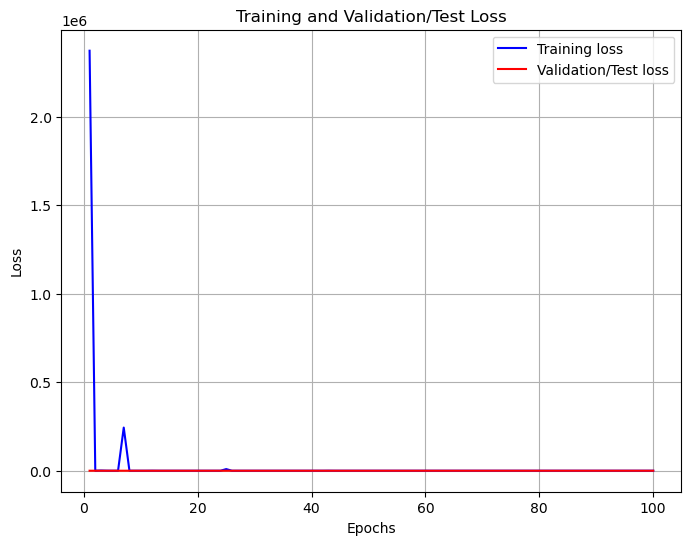

tensor(4.5057)
torch.Size([8000, 2])


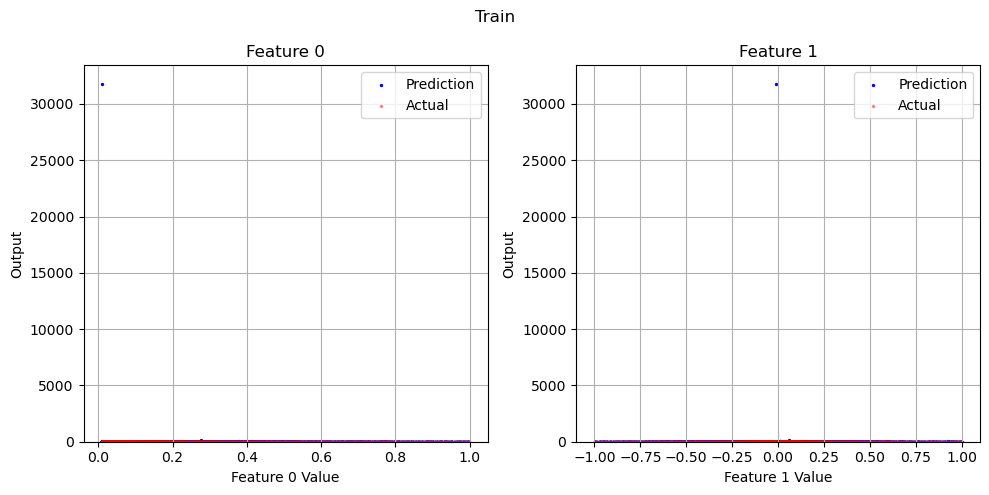

tensor(3.4389)
torch.Size([1000, 2])


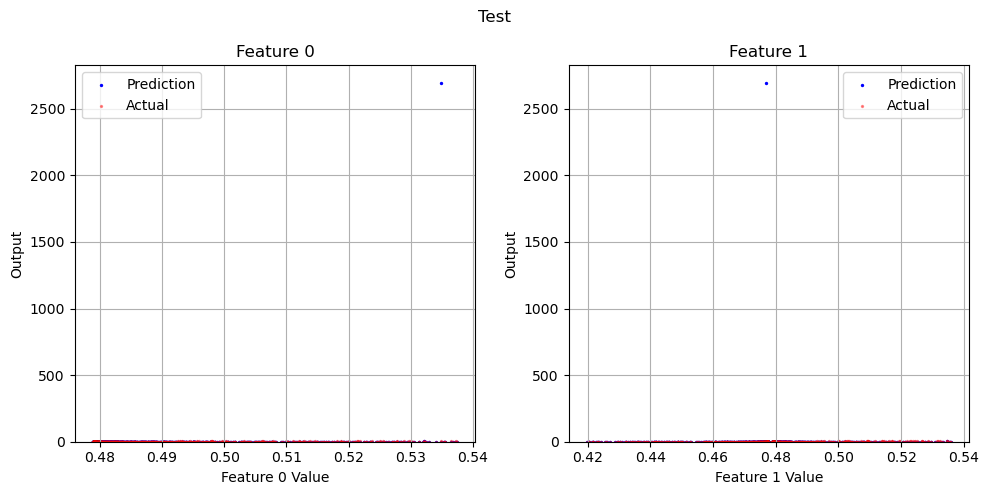

[[[['ln', 1], ['pi', 1], ['', 1], ['ln', 0]], [['cos', 1], ['g', 0], ['sin', 0], ['', 0]]], [[[1, '+', 0], [1], [1, '-', 0], [0, '+', 1]], [[1, '+', 0], [0, '-', 1], [0, '+', 1], [0, '/', 1]]], [[['cos', 1], ['g', 0], ['g', 1], ['sin', 0]], [['', 1], ['g', 0], ['g', 1], ['', 0]]], [[[0, '+', 1], [1, '/', 0], [0, '-', 1], [1, '*', 0]]]]


Processing Vectors: 302vector [00:00, 1505.70vector/s]

1.3185566663742065
[[['ln', 1], ['cos', 1]], [[1, '+', 0], [1, '+', 0]], [['cos', 1], ['', 1]], [[0, '+', 1]]]


Processing Vectors: 10263vector [00:06, 1492.41vector/s]

0.40447524189949036
[[['ln', 1], ['sin', 0]], [[1, '-', 0], [0, '/', 1]], [['cos', 1], ['', 0]], [[1, '*', 0]]]


Processing Vectors: 16384vector [00:10, 1505.32vector/s]


tensor(0.4045)


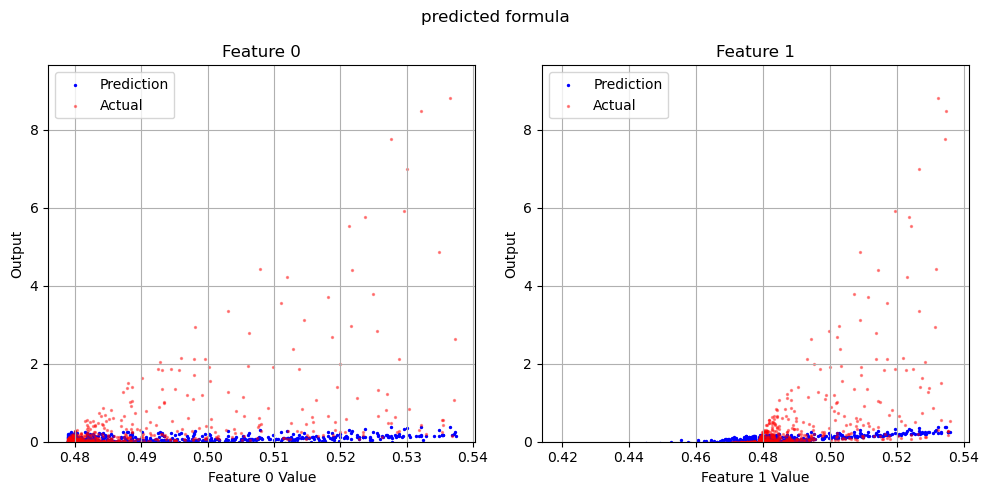

In [8]:
equation_size = 30
batch_size = 60
num_epochs = 100
prob_size = 4
losses = []
formulas = []
equations = [4]
for n_equation in equations:
    print(n_equation)
    x, y = data_prep(dataset, "test", n_equation, 30)
    input_size = x.shape[1]
    model = [input_size, input_size, 2, 2, 1]
    formuler = Formuler(model).to(device)
    optimizer = optim.Adam(formuler.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)
    criterion =  torch.nn.L1Loss()
    min_loss, min_for = run_experiment(formuler, dataset, n_equation, plot=True, save=False, dist=False)
    losses.append(min_loss)
    formulas.append(min_for)

In [9]:
losses, formulas

([0.40447524189949036],
 [[[['ln', 1], ['sin', 0]],
   [[1, '-', 0], [0, '/', 1]],
   [['cos', 1], ['', 0]],
   [[1, '*', 0]]]])

: 

### Sci-Net output

In [6]:
equation_size = 30
batch_size = 60
num_epochs = 100
prob_size = 4
n_equation = 5
df = pd.read_csv("scinet_output.csv")
x, y = df.iloc[:, :-2], df.iloc[:, -1]
input_size = x.shape[1]
model = [input_size, input_size , 3, 2, 1]
formuler = Formuler(model).to(device)
optimizer = optim.Adam(formuler.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)
criterion =  torch.nn.MSELoss()
min_loss, min_for = run_experiment(formuler, df, n_equation, plot=True, save=False, dist=False, scinet=True)


tensor([[7.7620e+20, 8.1590e+20],
        [5.8505e+18, 6.1724e+18],
        [1.2804e+23, 1.2948e+23],
        [2.3711e+23, 2.3751e+23],
        [2.5978e+20, 2.7357e+20],
        [3.8012e+21, 3.9794e+21],
        [2.8793e+21, 3.0171e+21],
        [5.2315e+22, 5.3830e+22],
        [3.2787e+20, 3.4510e+20],
        [1.7860e+10, 1.8846e+10],
        [3.8028e+22, 3.9303e+22],
        [2.1329e+20, 2.2466e+20],
        [1.5291e+24, 1.4369e+24],
        [1.4061e+23, 1.4209e+23],
        [4.0125e+21, 4.1999e+21],
        [1.5981e+18, 1.6864e+18],
        [2.4739e+21, 2.5932e+21],
        [1.2788e+17, 1.3495e+17],
        [2.3299e+21, 2.4431e+21],
        [3.5545e+22, 3.6765e+22],
        [2.2040e+18, 2.3262e+18],
        [6.9826e+19, 7.3610e+19],
        [1.5249e+24, 1.4367e+24],
        [2.0560e+23, 2.0665e+23],
        [7.2532e+21, 7.5720e+21],
        [1.2065e+15, 1.2730e+15],
        [3.6382e+20, 3.8295e+20],
        [5.3309e+22, 5.4845e+22],
        [9.8080e+23, 9.3256e+23],
        [8.316

RuntimeError: The size of tensor a (10) must match the size of tensor b (4) at non-singleton dimension 2